In [1]:
#set up sys
import os, sys
sys.path.append('../PMC_func')


#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from collections import Counter

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import ConvergenceMetric
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import pickle
import warnings
warnings.filterwarnings('ignore')

### Import Data
- Pickled Gensim Objects
- Composite Data Frame

In [2]:
nogram_filename = "../pickled_data/nogram_corpus.pkl"
bigram_filename = "../pickled_data/bigram_corpus.pkl"
trigram_filename = "../pickled_data/trigram_corpus.pkl"
df_lemmatized_texts = "../pickled_data/df_lemmatized_texts.pkl"

with open(nogram_filename, "rb") as f:
    nogram_list_lemmatized_texts, nogram_corpus, nogram_id2word = pickle.load(f)

with open(bigram_filename, "rb") as g:
    bigram_list_lemmatized_texts, bi_corpus, bi_id2word = pickle.load(g)
    
with open(trigram_filename, "rb") as h:
    trigram_list_lemmatized_texts, tri_corpus, tri_id2word = pickle.load(h)
    
with open(df_lemmatized_texts, "rb") as m:
    df_lemmatized_texts = pickle.load(m)

In [3]:
# store raw texts as a list for later
df_list = df_lemmatized_texts.text.tolist()

### Gensim LDA modeling - Hyper Parameter Tunning

#### Coherence Score

In [4]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

convergence_logger = ConvergenceMetric(logger='shell')

In [5]:
num_topics_list = list(range(5,20,5))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 4
iterations = 200
eval_every = 1
callbacks = [convergence_logger]

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=bi_id2word, 
                         num_topics=num_topics,
                         corpus=bi_corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_list_lemmatized_texts, dictionary=bi_id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics, "; score = ", coherence_score)

LDA model/coherence complete for num_topics =  5 ; score =  0.43638218492738473
LDA model/coherence complete for num_topics =  10 ; score =  0.4273241325287815
LDA model/coherence complete for num_topics =  15 ; score =  0.40056906895232464


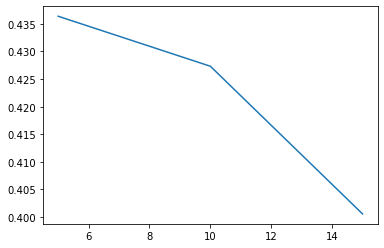

In [6]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution - 5 topics

In [35]:
opt_topic_index = 0
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

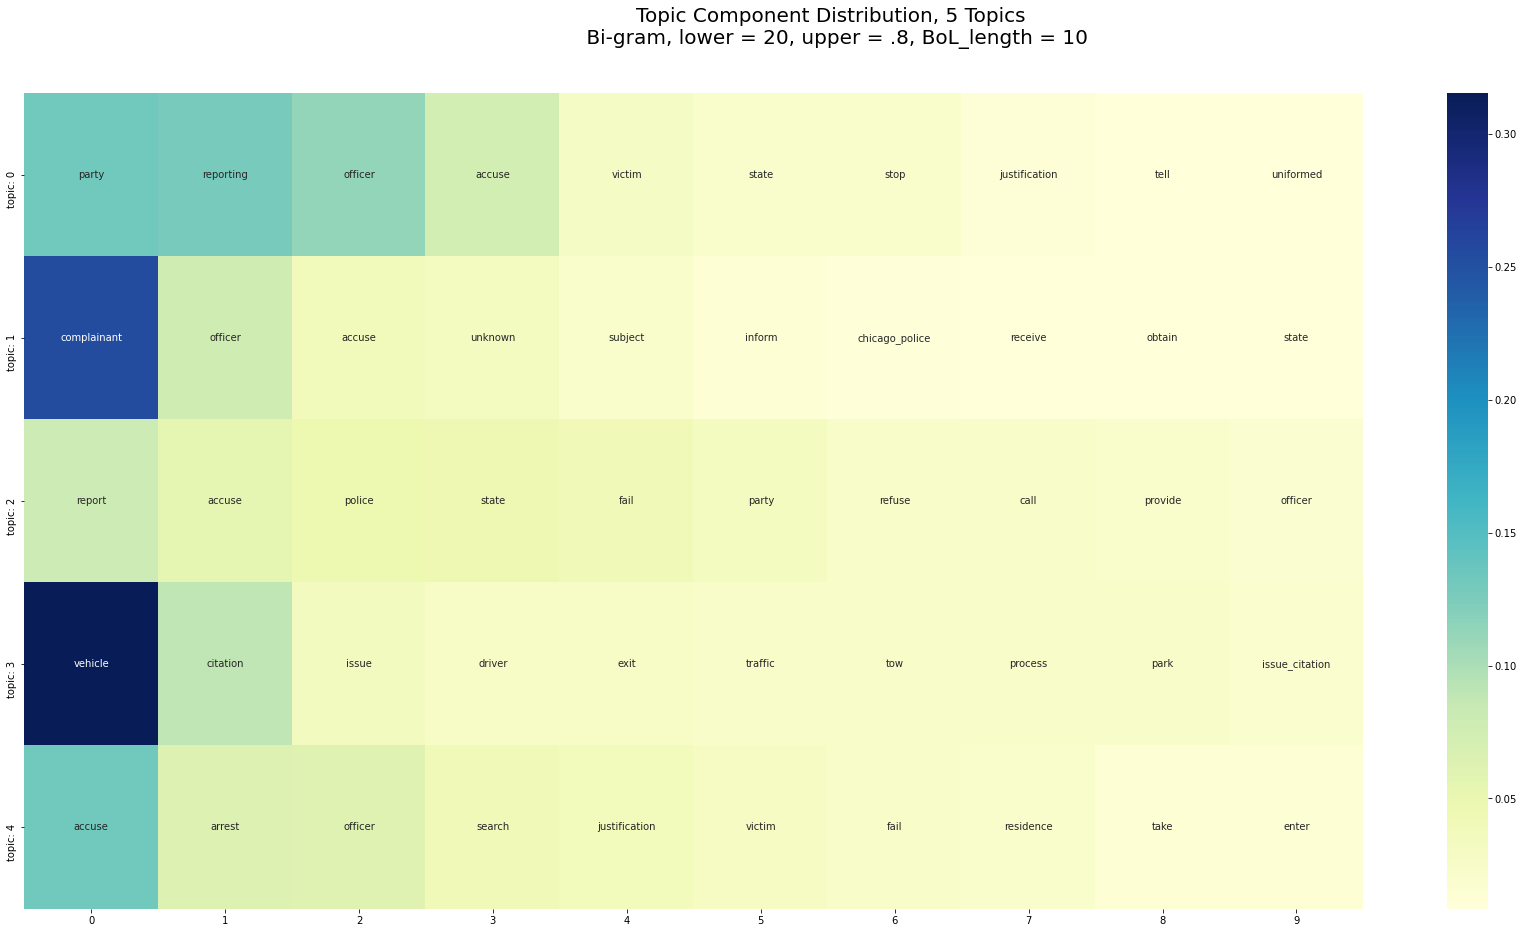

In [36]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n Bi-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_bigram_5topics1.png')

#### pyLDAvis Principal Component Visualization

In [9]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_bigram_5topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], bi_corpus, bi_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [10]:
dom_topic_df_5 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],bi_corpus, bigram_list_lemmatized_texts,df_list)
top_representatives_5 = PMC_module.return_top_representatives(dom_topic_df_5, num_reps = 10)

In [26]:
top_representatives_5[top_representatives_5['Dominant_Topic'] == 3].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
30,96,3.0,0.5245,"[vehicle, citation, issue, driver, exit, traff...","[victimallege, run, away, convenience_store, c...",Victimalleges that he was running away\nfrom a...
31,97,3.0,0.5036,"[vehicle, citation, issue, driver, exit, traff...","[victim, allege, run, away, convenience_store,...",Victim alleges that he was running away\nfrom ...
32,8029,3.0,0.4148,"[vehicle, citation, issue, driver, exit, traff...","[report, p.o, singleton, 19339, p.o, hale, 196...",It is reported that P.O. Singleton #19339\nand...
33,11061,3.0,0.4064,"[vehicle, citation, issue, driver, exit, traff...","[citation, indicate, hazard_light, issue_citat...","citation, which indicated that she had her\nha..."
34,16350,3.0,0.4010,"[vehicle, citation, issue, driver, exit, traff...","[plaintiff, allege, slam, vehicle, handcuff, p...",The plaintiff alleges that he was slammed\nont...
35,16351,3.0,0.4010,"[vehicle, citation, issue, driver, exit, traff...","[plaintiff, allege, slam, vehicle, handcuff, p...",The plaintiff alleges that he was slammed\nont...
36,11888,3.0,0.3964,"[vehicle, citation, issue, driver, exit, traff...","[inspect, vehicle, 8270, tour_duty, witness, d...",INSPECTING VEHICLE #8270 BEFORE\nHIS TOUR OF D...
37,12999,3.0,0.3913,"[vehicle, citation, issue, driver, exit, traff...","[complainant, allege, accuse, issue, citatior,...",The complainant alleges that the accused\nissu...
38,33172,3.0,0.3867,"[vehicle, citation, issue, driver, exit, traff...","[reporting, party, allege, accuse, officer, im...",The reporting party alleged that the accused\n...
39,20218,3.0,0.3740,"[vehicle, citation, issue, driver, exit, traff...","[allege, p.o, p.o, leave, assign, district, dr...",It is alleged that P.O. #1 and P.O. #2 left\nt...


In [27]:
topic_of_interest = 3
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_5[top_representatives_5['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 3
---------
Victimalleges that he was running away
from a convenience store in which he had
committed an armed robbery with a firearm
and when he exited the store he was
chased by a SUV patrol vehicle which
struck him. The vehicle crash injured his
right leg and left hip when he was dragged
underneath the carriage of the SUV.
------
Victim alleges that he was running away
from a convenience store in which he had
committed an armed robbery with a firearm
and when he exited the store he was
chased by a SUV patrol vehicle which
struck him. The vehicle crash injured his
right leg and left hip when he was dragged
underneath the carriage of the SUV.
------
It is reported that P.O. Singleton #19339
and P.O. Hale #19691 were conducting a
routine vehicle inspection of marked vehicle
#8615, at the beginning of their tour. It is
reported that during their inspection of said
vehicle, that they discovered that the in car
camera screen was cracked and that it
made it inoperative.
------
citat

#### Topic Component Distribution - 10 topics

In [37]:
opt_topic_index = 1
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

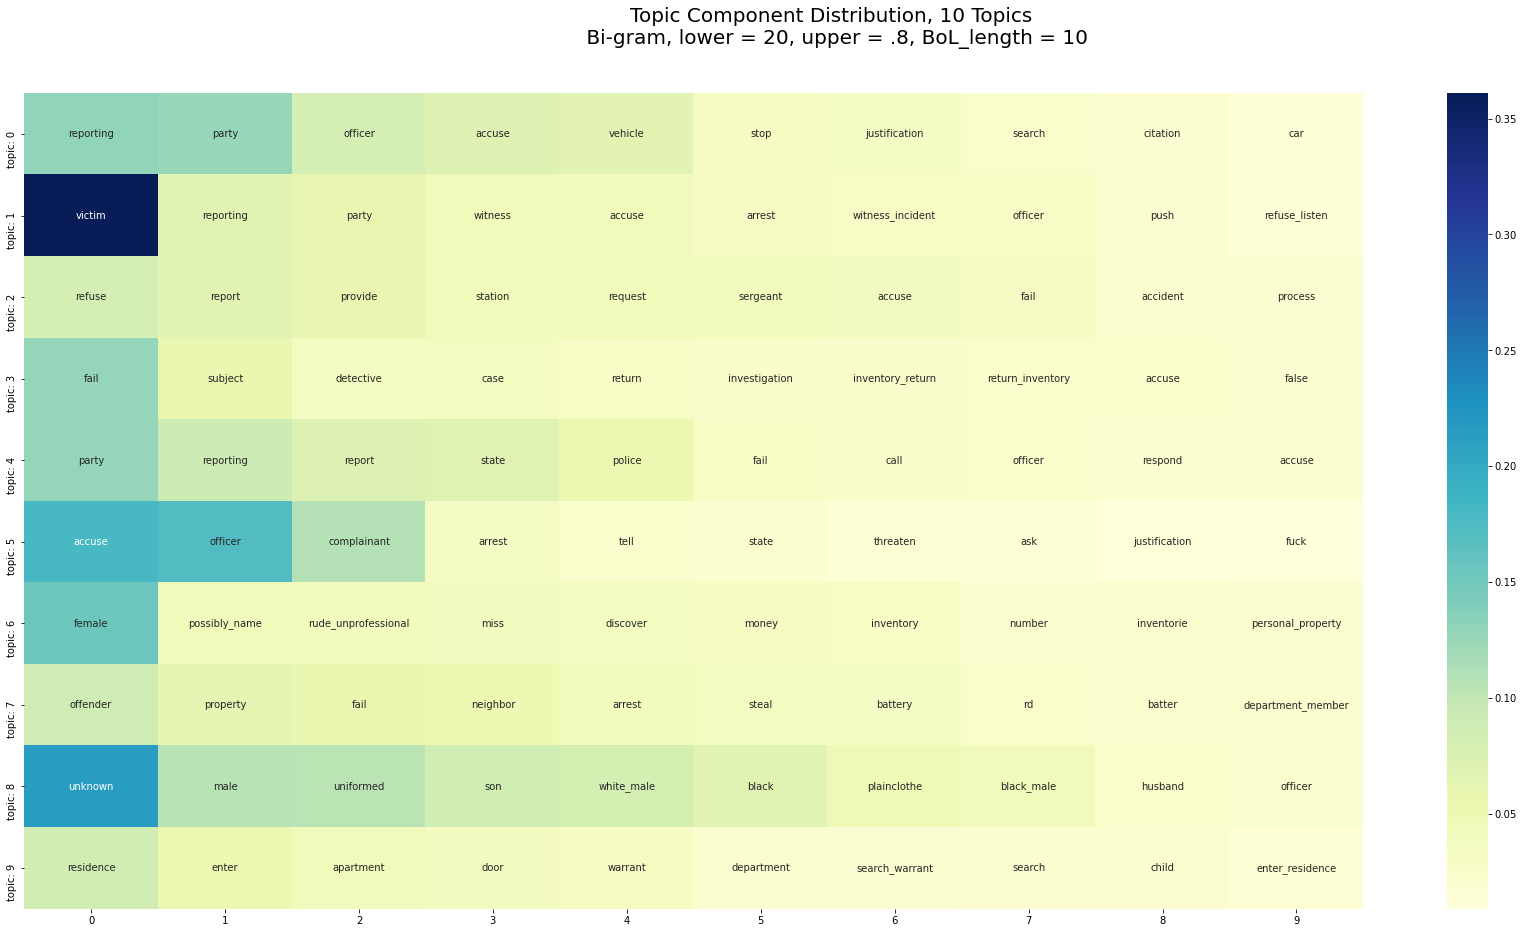

In [38]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 10 Topics \n Bi-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_bigram_10topics1.png')

#### pyLDAvis Principal Component Visualization

In [15]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_bi_10topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], bi_corpus, bi_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [17]:
dom_topic_df_10 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],bi_corpus, bigram_list_lemmatized_texts,df_list)
top_representatives_10 = PMC_module.return_top_representatives(dom_topic_df_10, num_reps = 10)

In [28]:
top_representatives_10[top_representatives_10['Dominant_Topic'] == 0].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
0,10426,0.0,0.7826,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
1,31550,0.0,0.7766,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
2,31551,0.0,0.7766,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
3,9319,0.0,0.7707,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, officer, gr...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
4,9318,0.0,0.7707,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, officer, gr...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
5,24304,0.0,0.7578,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, observe, marked_suv...",The reporting party alleges that he\nobserved ...
6,22727,0.0,0.7530,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, officer, re...",The reporting party alleged that the accused\n...
7,24303,0.0,0.7499,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, observe, marked_suv...",The reporting party alleges that he\nobserved ...
8,19234,0.0,0.7475,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, officer, st...",The reporting party alleges that the accused\n...
9,28641,0.0,0.7459,"[reporting, party, officer, accuse, vehicle, s...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...


In [29]:
topic_of_interest = 0
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_10[top_representatives_10['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 0
---------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS.
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
------
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
The reporting party alleged that the accused
stopped and searched him without
justifi

#### Topic Component Distribution - 15 topics

In [39]:
opt_topic_index = 2
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

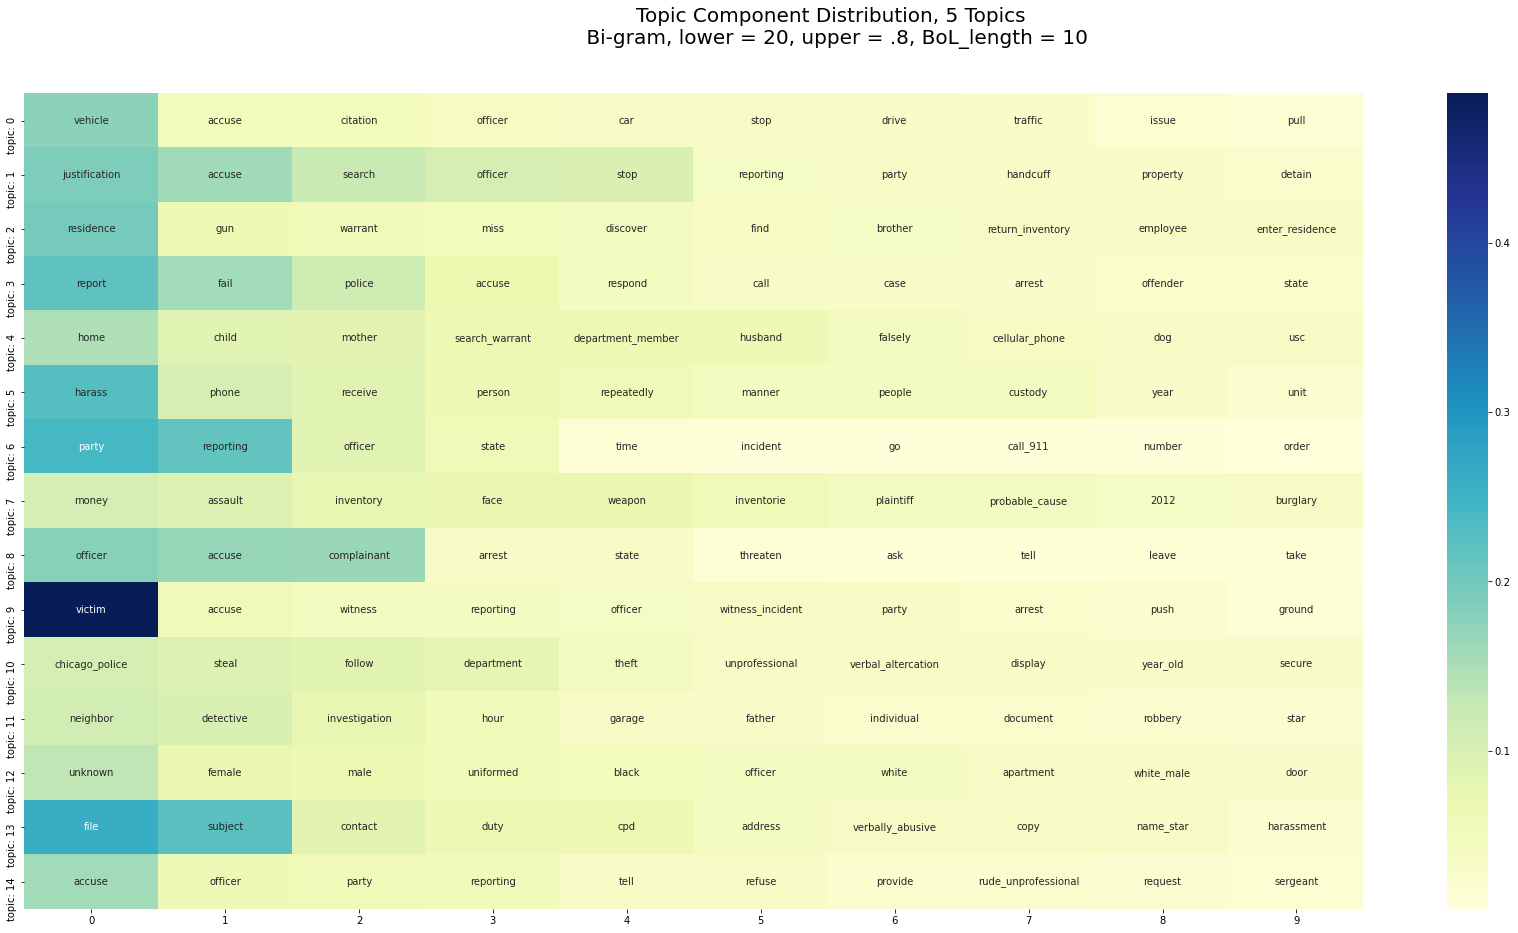

In [40]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n Bi-gram, lower = 20, upper = .8, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_bigram_15topics1.png')

#### pyLDAvis Principal Component Visualization

In [25]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_bigram_15topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], bi_corpus, bi_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [22]:
dom_topic_df_15 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],bi_corpus, bigram_list_lemmatized_texts,df_list)
top_representatives_15 = PMC_module.return_top_representatives(dom_topic_df_15, num_reps = 10)

In [33]:
top_representatives_15[top_representatives_15['Dominant_Topic'] == 0].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
0,4588,0.0,0.5658,"[vehicle, accuse, citation, officer, car, stop...","[drive, reckless, 3rd, 4th, vehicle, stop, red...",was driving reckless in that the\nwas the 3rd ...
1,11342,0.0,0.5506,"[vehicle, accuse, citation, officer, car, stop...","[e, traffic, stop, result, mr, es, issue, tick...","ing a traffic stop, as a result of which Mr.\n..."
2,22716,0.0,0.5470,"[vehicle, accuse, citation, officer, car, stop...","[complainant, state, stop, accuse, officer, di...",The complainant stated that he was\nstopped by...
3,22717,0.0,0.5433,"[vehicle, accuse, citation, officer, car, stop...","[complainant, state, stop, accuse, officer, di...",The complainant stated that he was\nstopped by...
4,12867,0.0,0.5387,"[vehicle, accuse, citation, officer, car, stop...","[complainant, allege, unknown, officer, conduc...",The complainant alleges that an unknown\noffic...
5,14936,0.0,0.5294,"[vehicle, accuse, citation, officer, car, stop...","[reporting, party, victim, allege, stop, detai...",The Reporting Party Victim alleged he was.\nst...
6,14937,0.0,0.5294,"[vehicle, accuse, citation, officer, car, stop...","[reporting, party, victim, allege, stop, detai...",The Reporting Party Victim alleged he was\nsto...
7,11362,0.0,0.5223,"[vehicle, accuse, citation, officer, car, stop...","[reporting, party, allege, traffic, stop, accu...",The reporting party alleged that the during a\...
8,4589,0.0,0.5207,"[vehicle, accuse, citation, officer, car, stop...","[reporting, party, witness, allege, accuse, dr...",The Reporting Party Witness alleged that\nthe ...
9,28035,0.0,0.5206,"[vehicle, accuse, citation, officer, car, stop...","[reporting, party, allege, accuse, stop, passe...",The reporting party alleged that the accused\n...


In [34]:
topic_of_interest = 0
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_15[top_representatives_15['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 0
---------
was driving reckless in that the
was the 3rd or 4th vehicle stopped
red light. When the light turned green
without having any emergency
activated drove through the left
lane and then cut back into the regular
of traffic, cutting off other vehicles and
causing an accident.
------
ing a traffic stop, as a result of which Mr.
eS issued two tickets, it is alleged
that the accused officer refused to accept
AAA Bond Card and instead
confiscated his license. It is also alleged
that the accused Officer was rude and
disrespectful when, after Mr. handed
him his AAA card, the accused threw the
card back into Mr. car and stated
words to the effect of “if you throw
something at me, | will throw something
back at you.”
------
The complainant stated that he was
stopped by the accused officer for
disregarding a stop sign and driving with a
suspended license The accused officer
drove his car, a 1999 GS Buick Regal
bearing license plate from the
location of the street stop to the 004t